# Equity Analysis: Who is Affected by Arxiv Review Paper Policies?

This notebook analyzes whether arxiv policies restricting review/position papers disproportionately affect certain groups:
- **Junior researchers** (low h-index, fewer publications)
- **Authors from less prestigious institutions**
- **Authors from the Global South**
- **Researchers in certain subfields**

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

DATA_DIR = Path('../data/openalex')

## 1. Load Data

In [3]:
# Load works data
print("Loading works...")
with open(DATA_DIR / 'works_enriched.json') as f:
    works = json.load(f)
print(f"  Loaded {len(works):,} works")

# Load author profiles (JSONL format)
print("Loading author profiles...")
author_profiles = {}
with open(DATA_DIR / 'author_profiles.jsonl') as f:
    for line in f:
        profile = json.loads(line.strip())
        author_profiles[profile['author_id']] = profile
print(f"  Loaded {len(author_profiles):,} author profiles")

# Load institution profiles
print("Loading institution profiles...")
with open(DATA_DIR / 'institution_profiles.json') as f:
    institution_profiles = json.load(f)
print(f"  Loaded {len(institution_profiles):,} institution profiles")

Loading works...
  Loaded 102,447 works
Loading author profiles...
  Loaded 244,345 author profiles
Loading institution profiles...
  Loaded 3,063 institution profiles


## 2. Build Analysis DataFrames

In [4]:
# Build paper-level dataframe
paper_records = []
for arxiv_id, work in works.items():
    paper_records.append({
        'arxiv_id': arxiv_id,
        'paper_type': work.get('paper_type', 'unknown'),
        'category': work.get('category', ''),
        'publication_year': work.get('publication_year'),
        'cited_by_count': work.get('cited_by_count', 0),
        'num_authors': len(work.get('authorships', [])),
        'primary_topic': work.get('primary_topic', {}).get('name', '') if work.get('primary_topic') else '',
        'primary_subfield': work.get('primary_topic', {}).get('subfield', '') if work.get('primary_topic') else '',
        'primary_field': work.get('primary_topic', {}).get('field', '') if work.get('primary_topic') else '',
    })

papers_df = pd.DataFrame(paper_records)
print(f"Papers DataFrame: {len(papers_df):,} rows")
print(f"\nPaper type distribution:")
print(papers_df['paper_type'].value_counts())

Papers DataFrame: 102,447 rows

Paper type distribution:
paper_type
unknown    77330
regular    21487
review      3616
other         14
Name: count, dtype: int64


In [5]:
# Build author-paper level dataframe (one row per author per paper)
author_paper_records = []

for arxiv_id, work in works.items():
    paper_type = work.get('paper_type', 'unknown')
    category = work.get('category', '')
    
    for authorship in work.get('authorships', []):
        author_id = authorship.get('author_id', '')
        if not author_id:
            continue
            
        # Get author profile
        profile = author_profiles.get(author_id, {})
        
        # Get institution info (first institution)
        inst_ids = authorship.get('institution_ids', [])
        inst_id = inst_ids[0] if inst_ids else None
        inst_profile = institution_profiles.get(inst_id, {}) if inst_id else {}
        
        author_paper_records.append({
            'arxiv_id': arxiv_id,
            'paper_type': paper_type,
            'category': category,
            'author_id': author_id,
            'author_position': authorship.get('position', ''),
            'is_first_author': authorship.get('position') == 'first',
            'is_last_author': authorship.get('position') == 'last',
            # Author metrics
            'author_h_index': profile.get('h_index', 0),
            'author_works_count': profile.get('works_count', 0),
            'author_cited_by_count': profile.get('cited_by_count', 0),
            'author_i10_index': profile.get('i10_index', 0),
            # Institution metrics
            'institution_id': inst_id,
            'institution_name': inst_profile.get('display_name', ''),
            'institution_h_index': inst_profile.get('h_index', 0),
            'institution_country': inst_profile.get('country_code', ''),
            'institution_type': inst_profile.get('type', ''),
            'is_global_south': inst_profile.get('is_global_south', False),
        })

author_papers_df = pd.DataFrame(author_paper_records)
print(f"Author-Paper DataFrame: {len(author_papers_df):,} rows")

Author-Paper DataFrame: 468,793 rows


## 3. Career Stage Analysis

Are review paper authors more junior (lower h-index, fewer publications)?

In [6]:
# Filter to review vs regular papers only
review_authors = author_papers_df[author_papers_df['paper_type'] == 'review']
regular_authors = author_papers_df[author_papers_df['paper_type'] == 'regular']

print(f"Review paper author-instances: {len(review_authors):,}")
print(f"Regular paper author-instances: {len(regular_authors):,}")

Review paper author-instances: 15,172
Regular paper author-instances: 98,844


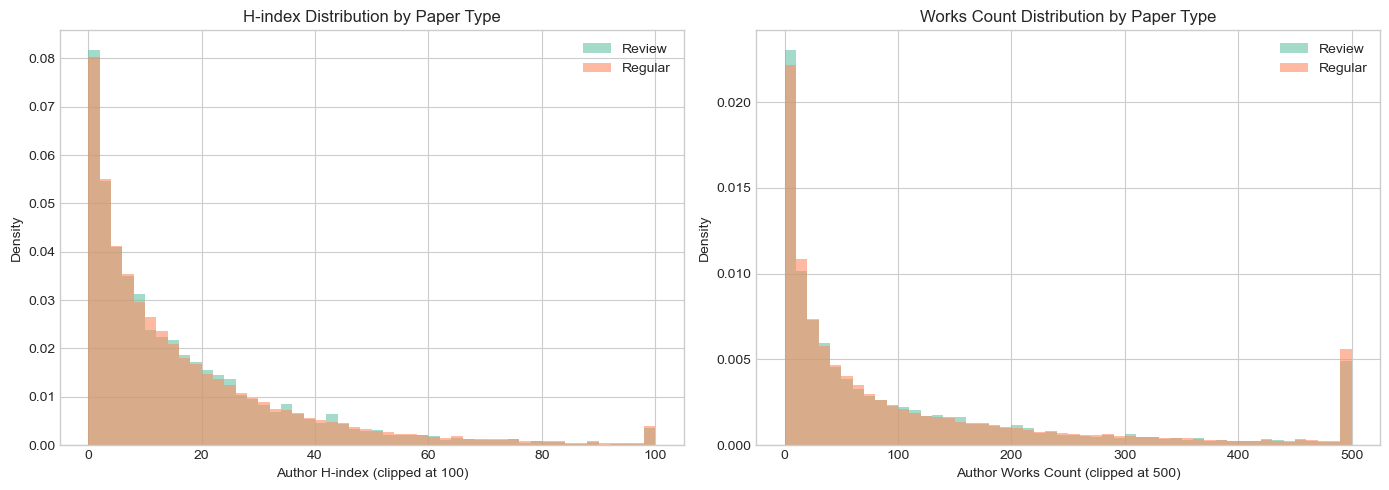

In [7]:
# Compare h-index distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# H-index distribution
ax1 = axes[0]
ax1.hist(review_authors['author_h_index'].clip(upper=100), bins=50, alpha=0.6, label='Review', density=True)
ax1.hist(regular_authors['author_h_index'].clip(upper=100), bins=50, alpha=0.6, label='Regular', density=True)
ax1.set_xlabel('Author H-index (clipped at 100)')
ax1.set_ylabel('Density')
ax1.set_title('H-index Distribution by Paper Type')
ax1.legend()

# Works count distribution
ax2 = axes[1]
ax2.hist(review_authors['author_works_count'].clip(upper=500), bins=50, alpha=0.6, label='Review', density=True)
ax2.hist(regular_authors['author_works_count'].clip(upper=500), bins=50, alpha=0.6, label='Regular', density=True)
ax2.set_xlabel('Author Works Count (clipped at 500)')
ax2.set_ylabel('Density')
ax2.set_title('Works Count Distribution by Paper Type')
ax2.legend()

plt.tight_layout()
plt.show()

In [8]:
# Statistical tests
print("=" * 60)
print("CAREER STAGE ANALYSIS")
print("=" * 60)

for metric in ['author_h_index', 'author_works_count', 'author_cited_by_count']:
    review_vals = review_authors[metric].dropna()
    regular_vals = regular_authors[metric].dropna()
    
    # Mann-Whitney U test (non-parametric)
    stat, p_value = stats.mannwhitneyu(review_vals, regular_vals, alternative='two-sided')
    
    print(f"\n{metric}:")
    print(f"  Review:  median={review_vals.median():.1f}, mean={review_vals.mean():.1f}")
    print(f"  Regular: median={regular_vals.median():.1f}, mean={regular_vals.mean():.1f}")
    print(f"  Mann-Whitney U p-value: {p_value:.2e}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

CAREER STAGE ANALYSIS

author_h_index:
  Review:  median=10.0, mean=16.5
  Regular: median=10.0, mean=16.8
  Mann-Whitney U p-value: 6.29e-01
  Significant at α=0.05: No

author_works_count:
  Review:  median=47.0, mean=128.1
  Regular: median=48.0, mean=133.4
  Mann-Whitney U p-value: 1.56e-01
  Significant at α=0.05: No

author_cited_by_count:
  Review:  median=466.0, mean=3357.4
  Regular: median=460.0, mean=3356.5
  Mann-Whitney U p-value: 9.36e-01
  Significant at α=0.05: No


## 4. Institution Prestige Analysis

Do review paper authors come from less prestigious institutions?

In [9]:
# Filter to authors with institution data
review_with_inst = review_authors[review_authors['institution_h_index'] > 0]
regular_with_inst = regular_authors[regular_authors['institution_h_index'] > 0]

print(f"Review authors with institution data: {len(review_with_inst):,}")
print(f"Regular authors with institution data: {len(regular_with_inst):,}")

Review authors with institution data: 455
Regular authors with institution data: 1,916


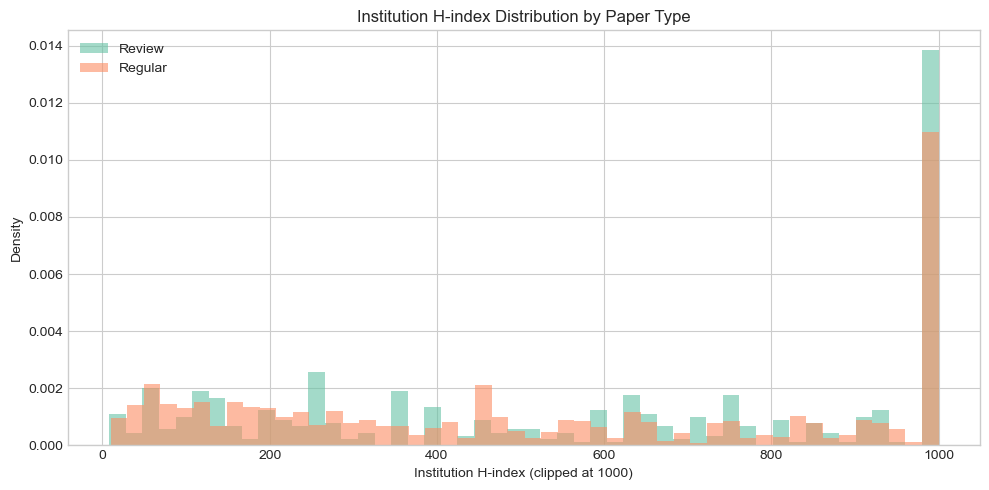

In [10]:
# Compare institution h-index
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(review_with_inst['institution_h_index'].clip(upper=1000), bins=50, alpha=0.6, label='Review', density=True)
ax.hist(regular_with_inst['institution_h_index'].clip(upper=1000), bins=50, alpha=0.6, label='Regular', density=True)
ax.set_xlabel('Institution H-index (clipped at 1000)')
ax.set_ylabel('Density')
ax.set_title('Institution H-index Distribution by Paper Type')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# Statistical test for institution prestige
print("=" * 60)
print("INSTITUTION PRESTIGE ANALYSIS")
print("=" * 60)

review_inst_h = review_with_inst['institution_h_index'].dropna()
regular_inst_h = regular_with_inst['institution_h_index'].dropna()

stat, p_value = stats.mannwhitneyu(review_inst_h, regular_inst_h, alternative='two-sided')

print(f"\nInstitution H-index:")
print(f"  Review:  median={review_inst_h.median():.1f}, mean={review_inst_h.mean():.1f}")
print(f"  Regular: median={regular_inst_h.median():.1f}, mean={regular_inst_h.mean():.1f}")
print(f"  Mann-Whitney U p-value: {p_value:.2e}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

INSTITUTION PRESTIGE ANALYSIS

Institution H-index:
  Review:  median=641.0, mean=692.6
  Regular: median=474.0, mean=607.5
  Mann-Whitney U p-value: 2.22e-03
  Significant at α=0.05: Yes


In [12]:
# Institution type breakdown
print("\nInstitution Type Breakdown:")
print("\nReview papers:")
print(review_with_inst['institution_type'].value_counts(normalize=True).head(5))
print("\nRegular papers:")
print(regular_with_inst['institution_type'].value_counts(normalize=True).head(5))


Institution Type Breakdown:

Review papers:
institution_type
education    0.742857
company      0.074725
facility     0.068132
nonprofit    0.043956
other        0.039560
Name: proportion, dtype: float64

Regular papers:
institution_type
education    0.680063
facility     0.168580
company      0.071503
other        0.038100
nonprofit    0.017223
Name: proportion, dtype: float64


## 5. Geographic Equity Analysis

Are authors from the Global South disproportionately affected?

In [13]:
# Global South percentage by paper type
print("=" * 60)
print("GEOGRAPHIC EQUITY ANALYSIS")
print("=" * 60)

review_gs_pct = review_with_inst['is_global_south'].mean() * 100
regular_gs_pct = regular_with_inst['is_global_south'].mean() * 100

print(f"\nGlobal South Author Percentage:")
print(f"  Review papers:  {review_gs_pct:.1f}%")
print(f"  Regular papers: {regular_gs_pct:.1f}%")

# Chi-square test
contingency = pd.crosstab(author_papers_df[author_papers_df['institution_h_index'] > 0]['paper_type'], 
                          author_papers_df[author_papers_df['institution_h_index'] > 0]['is_global_south'])
if 'review' in contingency.index and 'regular' in contingency.index:
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency.loc[['review', 'regular']])
    print(f"\n  Chi-square p-value: {p_value:.2e}")
    print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

GEOGRAPHIC EQUITY ANALYSIS

Global South Author Percentage:
  Review papers:  6.2%
  Regular papers: 15.0%

  Chi-square p-value: 9.16e-07
  Significant at α=0.05: Yes


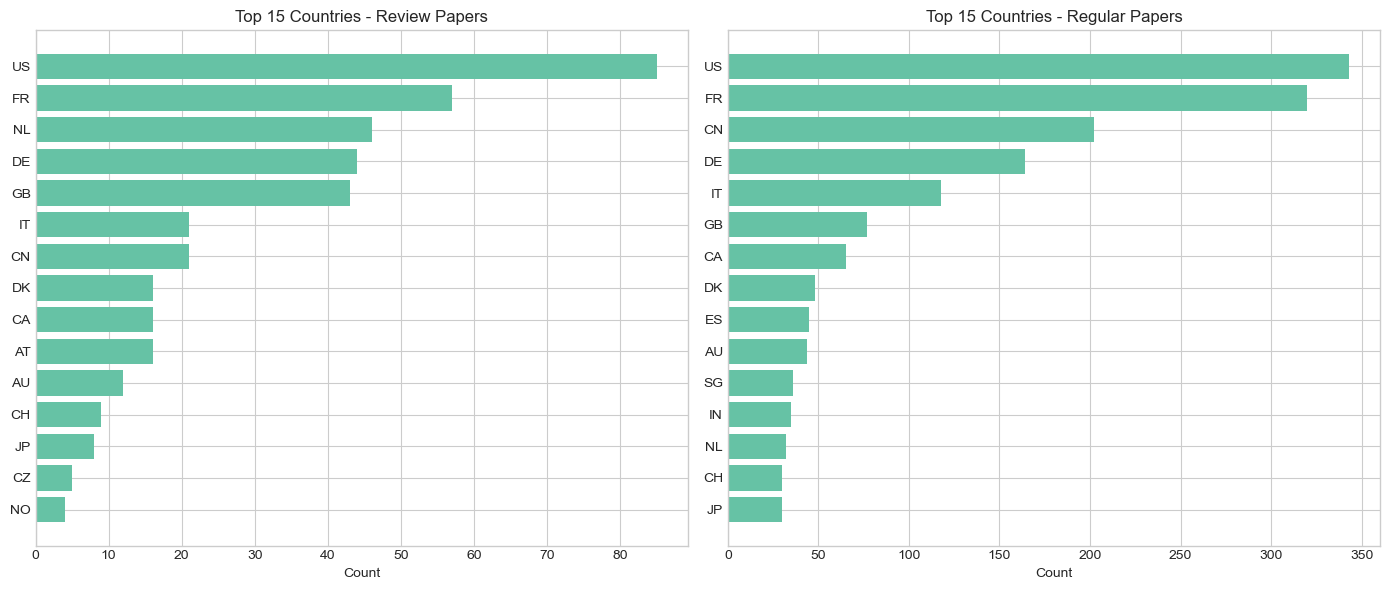

In [14]:
# Country breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Review papers - top countries
review_countries = review_with_inst['institution_country'].value_counts().head(15)
axes[0].barh(range(len(review_countries)), review_countries.values)
axes[0].set_yticks(range(len(review_countries)))
axes[0].set_yticklabels(review_countries.index)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 15 Countries - Review Papers')
axes[0].invert_yaxis()

# Regular papers - top countries
regular_countries = regular_with_inst['institution_country'].value_counts().head(15)
axes[1].barh(range(len(regular_countries)), regular_countries.values)
axes[1].set_yticks(range(len(regular_countries)))
axes[1].set_yticklabels(regular_countries.index)
axes[1].set_xlabel('Count')
axes[1].set_title('Top 15 Countries - Regular Papers')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Topic/Field Analysis

Are certain research topics more affected?

In [15]:
# Review rate by primary subfield
subfield_stats = papers_df.groupby('primary_subfield').agg({
    'arxiv_id': 'count',
    'paper_type': lambda x: (x == 'review').mean()
}).rename(columns={'arxiv_id': 'count', 'paper_type': 'review_rate'})

# Filter to subfields with enough papers
subfield_stats = subfield_stats[subfield_stats['count'] >= 100].sort_values('review_rate', ascending=False)

print("=" * 60)
print("TOPIC/FIELD ANALYSIS")
print("=" * 60)
print("\nTop 15 Subfields by Review Paper Rate (min 100 papers):")
print(subfield_stats.head(15).to_string())

TOPIC/FIELD ANALYSIS

Top 15 Subfields by Review Paper Rate (min 100 papers):
                                                      count  review_rate
primary_subfield                                                        
Safety Research                                         570     0.301754
Health Informatics                                      267     0.262172
Communication                                           213     0.145540
Management of Technology and Innovation                 109     0.137615
Management Information Systems                          592     0.135135
Education                                               259     0.135135
Sociology and Political Science                        1124     0.120996
Computer Science Applications                           620     0.116129
Safety, Risk, Reliability and Quality                   182     0.115385
Information Systems and Management                      495     0.115152
Political Science and International Relations 

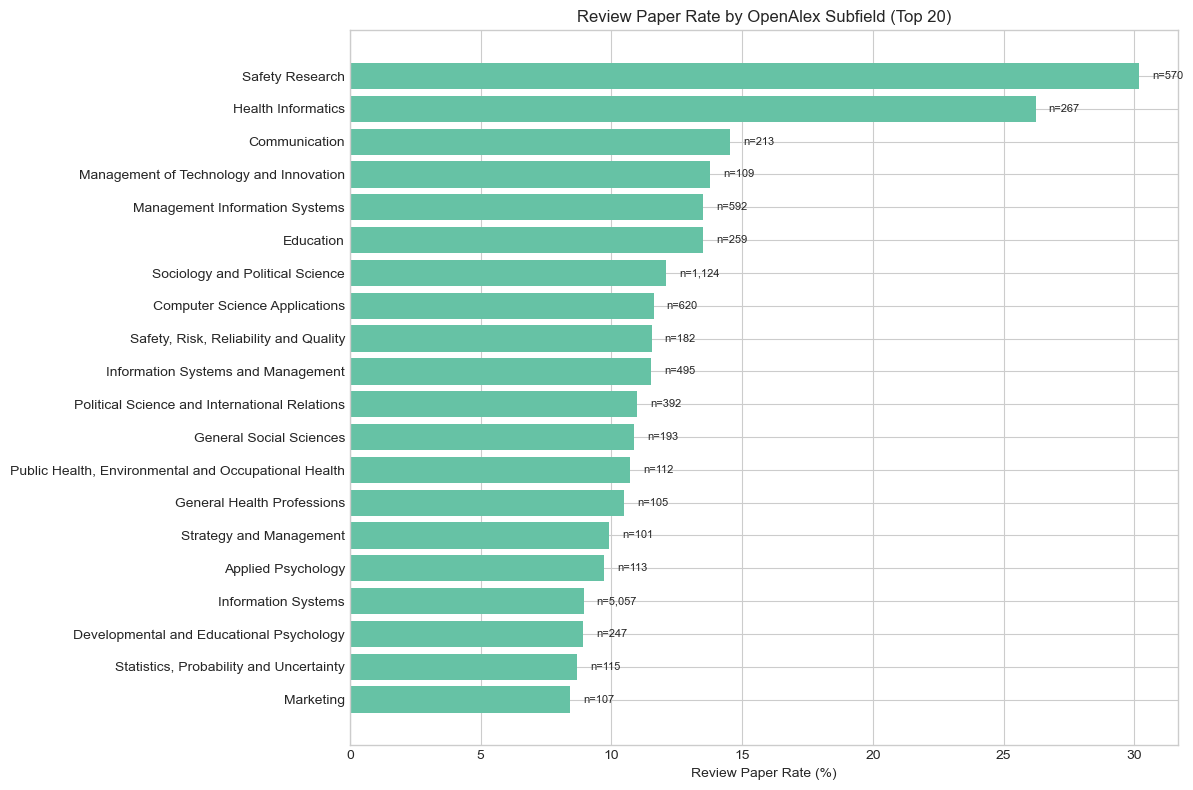

In [16]:
# Visualize review rates by subfield
top_subfields = subfield_stats.head(20)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(range(len(top_subfields)), top_subfields['review_rate'] * 100)
ax.set_yticks(range(len(top_subfields)))
ax.set_yticklabels(top_subfields.index)
ax.set_xlabel('Review Paper Rate (%)')
ax.set_title('Review Paper Rate by OpenAlex Subfield (Top 20)')
ax.invert_yaxis()

# Add count annotations
for i, (idx, row) in enumerate(top_subfields.iterrows()):
    ax.annotate(f'n={int(row["count"]):,}', xy=(row['review_rate'] * 100 + 0.5, i), va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [17]:
# Review rate by arxiv category
category_stats = papers_df.groupby('category').agg({
    'arxiv_id': 'count',
    'paper_type': lambda x: (x == 'review').mean()
}).rename(columns={'arxiv_id': 'count', 'paper_type': 'review_rate'})

category_stats = category_stats.sort_values('review_rate', ascending=False)

print("\nReview Rate by Arxiv Category:")
print(category_stats.to_string())


Review Rate by Arxiv Category:
          count  review_rate
category                    
cs-CY      2744     0.293003
cs-SE      5161     0.117225
cs-HC      4619     0.116692
cs-IR      2791     0.091365
cs-CR      6317     0.063479
cs-AI      7012     0.059042
cs-CL     18772     0.014596
cs-RO     10719     0.009329
cs-LG     17684     0.009161
cs-CV     26628     0.002328


## 7. Intersectional Analysis

Combined effects: Junior + Less Prestigious + Global South

In [18]:
# Define "junior" as below median h-index
median_h = author_papers_df['author_h_index'].median()
median_inst_h = author_papers_df[author_papers_df['institution_h_index'] > 0]['institution_h_index'].median()

print(f"Median author h-index: {median_h}")
print(f"Median institution h-index: {median_inst_h}")

Median author h-index: 12.0
Median institution h-index: 627.0


In [19]:
# Create intersectional groups
df = author_papers_df[author_papers_df['institution_h_index'] > 0].copy()
df['is_junior'] = df['author_h_index'] < median_h
df['is_less_prestigious'] = df['institution_h_index'] < median_inst_h

# Calculate review rates for different groups
print("=" * 60)
print("INTERSECTIONAL ANALYSIS")
print("=" * 60)

groups = [
    ('All authors', df),
    ('Junior authors (below median h-index)', df[df['is_junior']]),
    ('Senior authors (above median h-index)', df[~df['is_junior']]),
    ('Less prestigious institution', df[df['is_less_prestigious']]),
    ('More prestigious institution', df[~df['is_less_prestigious']]),
    ('Global South', df[df['is_global_south']]),
    ('Global North', df[~df['is_global_south']]),
    ('Junior + Less prestigious', df[df['is_junior'] & df['is_less_prestigious']]),
    ('Junior + Global South', df[df['is_junior'] & df['is_global_south']]),
    ('Junior + Less prestigious + Global South', df[df['is_junior'] & df['is_less_prestigious'] & df['is_global_south']]),
]

print("\nReview Paper Rate by Author Group:")
print("-" * 60)
for name, group in groups:
    if len(group) > 0:
        review_rate = (group['paper_type'] == 'review').mean() * 100
        print(f"{name:45} {review_rate:5.2f}% (n={len(group):,})")

INTERSECTIONAL ANALYSIS

Review Paper Rate by Author Group:
------------------------------------------------------------
All authors                                    1.29% (n=35,200)
Junior authors (below median h-index)          1.75% (n=12,945)
Senior authors (above median h-index)          1.03% (n=22,255)
Less prestigious institution                   1.25% (n=17,540)
More prestigious institution                   1.33% (n=17,660)
Global South                                   0.29% (n=9,818)
Global North                                   1.68% (n=25,382)
Junior + Less prestigious                      1.62% (n=6,895)
Junior + Global South                          0.37% (n=3,207)
Junior + Less prestigious + Global South       0.18% (n=2,166)


In [20]:
# Heatmap: Junior x Prestige x Paper Type
pivot = df.pivot_table(
    values='arxiv_id', 
    index=['is_junior', 'is_less_prestigious'],
    columns='paper_type',
    aggfunc='count',
    fill_value=0
)

if 'review' in pivot.columns and 'regular' in pivot.columns:
    pivot['review_rate'] = pivot['review'] / (pivot['review'] + pivot['regular']) * 100
    print("\nReview Rate by Junior/Prestige Status:")
    print(pivot[['review', 'regular', 'review_rate']].to_string())


Review Rate by Junior/Prestige Status:
paper_type                     review  regular  review_rate
is_junior is_less_prestigious                              
False     False                   121      402    23.135755
          True                    108      525    17.061611
True      False                   114      386    22.800000
          True                    112      603    15.664336


## 8. Summary Statistics

In [21]:
print("=" * 60)
print("SUMMARY")
print("=" * 60)

print(f"\nDataset Size:")
print(f"  Papers analyzed: {len(papers_df):,}")
print(f"  Author-paper instances: {len(author_papers_df):,}")
print(f"  Unique authors: {author_papers_df['author_id'].nunique():,}")

print(f"\nPaper Types:")
for pt, count in papers_df['paper_type'].value_counts().items():
    print(f"  {pt}: {count:,} ({100*count/len(papers_df):.1f}%)")

print(f"\nKey Findings:")
print(f"  - Compare h-index medians above to see if review authors are more junior")
print(f"  - Compare institution h-index to see prestige differences")
print(f"  - Check Global South percentages for geographic disparities")
print(f"  - Review subfield analysis for topic-based effects")

SUMMARY

Dataset Size:
  Papers analyzed: 102,447
  Author-paper instances: 468,793
  Unique authors: 244,345

Paper Types:
  unknown: 77,330 (75.5%)
  regular: 21,487 (21.0%)
  review: 3,616 (3.5%)
  other: 14 (0.0%)

Key Findings:
  - Compare h-index medians above to see if review authors are more junior
  - Compare institution h-index to see prestige differences
  - Check Global South percentages for geographic disparities
  - Review subfield analysis for topic-based effects
